## Checklist

+ Pseudocode, well-written
    + [+] Synthesize paper 
    + [+] Demo flow
    + [+] Test on larger raster

[+] Get Rainfall Distributions
    + Local areas (circles)
    + Amounts over time 

+ Runoff
[+] Precipitation 
    [+] Uniform
    [+] Circular (API in progress)
    [+] Border
    [+] Time-varying
    

+ Infiltration (much smaller scale), so ruled out. 

### Testing
[+] a funcanim of pouring over time, and if things balance out. 
[+] Is mass conserved? 
[+] Water level on cell/1D slice over time
[+] Write results to disk (params, time)
[+] Quiver plot

### Strategies 
[+] Metrics
    + Water height/cell
    + mean flow rate (m^3/s)
[ ] % chance of inundation
    
[ ] Sites. 
    Sites of interest (e.g. population centers, rivers, etc)
[ ] Damages caused by flood vs water level
    + Blocking Flow (high Walls : what gets flooded in turn?)
    + block based on the water levels we observe

### Plotting
[+] Set rcParams
[+] 3D viz of a DEM
[+] Flowline of a point using D8, perhaps alternatives
    (then do salmon algo)
[+] test to see if a flood barrier works

### Theoretical Baselines
[+] Flow accumulation matrices
    [+] "Swimming Upstream" over gradient/slope fields
[+] Maximum flow velocity (mgh -> 1/2 m v^2)

### Upkeep
[+] Save figures
[+] Save data
[+] Refactor code

In [8]:
import scipy.stats as sts
import matplotlib.pyplot as plt
from scipy.ndimage import generic_filter

import numpy as np
import sklearn.datasets as ds
from matplotlib import cm
import matplotlib.animation as animation

import tqdm 

import time
from numba import jit

In [9]:
# set rcparams
#set linewidth
plt.rcParams['axes.linewidth'] = 0.8

/var/folders/6v/v3k0ftn92ld7ss4w20w4t8480000gn/T/ipykernel_75803/949018664.py:7: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
  ro, co = draw.circle(p,100 - p,5,test.shape)


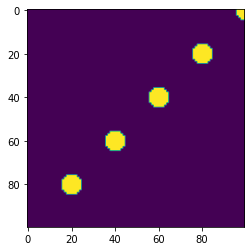

In [10]:
from skimage import draw

placements = range(0,100,20)
test = np.zeros((100,100))

for p in placements:
    ro, co = draw.circle(p,100 - p,5,test.shape)

    test[ro,co] = 1

plt.imshow(test)

In [11]:
def init_water(layer, fill = 1, kind = 'border'):
    # later is slice of CA with water heights

    water_layer = layer.copy()

    if kind == 'border':
    
        water_layer[0,:], water_layer[-1,:] = fill, fill
        water_layer[:,0], water_layer[:, -1] = fill, fill

    elif kind == 'everywhere':
        water_layer[:] = fill

    elif kind == 'circle':
        # generate a circle of rainfall in center
        pass
        

    return water_layer

directions = {
    0: 1,
    1: 2,
    2: 4,
    3: 8,
    5: 16,
    6: 32, 
    7: 64, 
    8: 128}

def find_direction(window, method  = 'Dinf'):
    # alias: Dinf in literature. Direct flow to lowest neighbor(s)

    # Keys for neighbor positions relative to kernel
    # 0 1 2
    # 3 4 5
    # 6 7 8 
    
    # window has flat array positions
    center = window[4]
    lower_cells = np.where(window < center, window, float('inf'))
    
    # Get indices of downstream cells
    idxs = np.where(lower_cells < float('inf'))
    idxs = list(*idxs)
    
    return np.sum([directions[i] for i in idxs]) if len(idxs) > 0 else 0

def init_directions(layer, method = 'Dinf'):
    # idx for elevation values
    moore_kernel = np.ones((3,3)) 
    
    # TODO: better cval for constant mode
    # maybe repeat? 
    directions = generic_filter(
                    layer,
                    find_direction,
                    footprint = moore_kernel,  
                    mode = 'constant',
                    cval = np.nan)

    # Set border of directions to 0
    directions[0,:] = 0
    directions[:,0] = 0
    directions[-1,:] = 0
    directions[:,-1] = 0
    
    return directions

def calculate_slope(window, d = 1, degrees = True):
    # d is width of a cell

    # 0 1 2 3 [4] 5 6 7 8
    # 0 1 2 3     4 5 6 7

    # if central cell is no_data, return itself
    if window[4] == np.nan or window[4] < 0:
        return window[4]
    
    df_dx = (np.sum(window[[2, 5, 5, 8]])  - np.sum(window[[0, 3, 3, 6]]))/8*d
    df_dy = (np.sum(window[[6, 7, 7, 8]])  - np.sum(window[[0, 1, 1, 2]]))/8*d

    rise_run = np.sqrt(df_dx**2 + df_dy**2)

    if degrees:
        # rise/run -> value in degrees 
        # 57.29578 ~ 180/pi (acceptable precision)
        return np.arctan(rise_run) * 57.29578

    else:
        #return absolute value of rise/run
        return rise_run

def init_slope(dem_layer):
    # Fill out gradients (degrees) for each cell in grid
    # idx for elevation values

    moore_kernel = np.ones((3,3))    
    slopes = generic_filter(
                dem_layer,
                calculate_slope,
                footprint = moore_kernel,  
                mode = 'nearest',
                cval = 0)

    return slopes
    

In [12]:
def create_basin(N = 5, layers = 5, seed = 1):
    # Return a toy elevation model
    # layers can be :[DEM, WaterLevels, Slope, Direction, ICVols]
    
    #set seed for reproducibility
    np.random.seed(seed)

    grid = np.zeros((N,N,layers))

    for i in range(N):
        for j in range(N):
            # Use small scale as tally is easier for testing
            grid[i,j,0] -= 50**2*sts.norm.pdf(i*2, loc = N/2, scale = N) + \
                        50**2*sts.norm.pdf(j*2, loc = N/2, scale = N) - 500

    '''
    dem = np.array(
    [
        [10,10,10,10,10],
        [10,8 ,8 ,8 ,10],
        [10,8 ,5,8 ,10],
        [10,8 ,8 ,8 ,10],
        [10,10,10,10,10],
    ]
    )

    grid[...,0] = dem'''

    return init_grid(grid)



def init_grid(grid, **kwargs):
    # Initialise each layer of the grid
    # Check number of features in last column 
    # if 1, then it is a DEM

    if len(grid.shape) == 2:
        # Add additional columns for water column, direction, and slope
        dem  = grid
        grid = np.zeros((grid.shape[0], grid.shape[1], 5))
        grid[...,0] = dem    

    grid = grid.copy()

    fill = kwargs.get('fill', 1)
    kind = kwargs.get('kind', 'border')

    grid[...,1] = init_water(grid[...,1], fill = fill, kind = kind)
    grid[...,2] = init_slope(grid[...,0])
    grid[...,3] = init_directions(grid[...,0])
    
    return grid

In [13]:
def dist(
    layer,
    benchmark = None,

    ax = None,
    title = "",
    bins=20, 
    color='w', 
    edgecolor='k', 
    figsize=(5,3), 
    ):

    if ax == None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1,1,1)

    ax.hist(
        layer.flatten(),
        bins = bins,
        color = color, 
        hatch = '///',
        edgecolor = edgecolor)

    ax.set_title(
        title)

    if benchmark:
        ax.axvline(
            benchmark,
            color = 'red',
            label = f''
        )

        ax.plot(
            0,0,',',
            label = f'')
        ax.legend(loc = "upper left")

    adjust_spines(ax, ['bottom'])
    ax.set_xlabel(f'')
    
    plt.tight_layout()
    return ax
        
def adjust_spines(ax, spines, offset = 0):
        for loc, spine in ax.spines.items():
            if loc in spines:
                spine.set_position(('outward', offset))  # outward by offset points
                #spine.set_smart_bounds(True)
            else:
                spine.set_color('none')
        # turn off ticks where there is no spine
        if 'left' in spines:
            ax.yaxis.set_ticks_position('left')
        else:
            # no yaxis ticks
            ax.yaxis.set_ticks([])

        if 'bottom' in spines:
            ax.xaxis.set_ticks_position('bottom')
        else:
            # no xaxis ticks
            ax.xaxis.set_ticks([])


def plot_dem(dem, rotation = 30,  cmap = 'binary', ax = None):
    # A function that plots a DEM (or any 2d array) in 3d

    bins = dem.shape[0]
    dem = dem.flatten()

    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')

    hist, xedges, yedges = np.histogram2d(dem, dem, bins=bins, range=[[0, bins], [0, bins]])

    # Figure out anchors for each bar
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.1, yedges[:-1] + 0.1, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Construct arrays with the dimensions for each bar
    dx = dy = 1 * np.ones_like(zpos)
    dz = dem

    cmap = cm.get_cmap(cmap) # discrete colormap
    max_height = np.max(dz)   # max height
    min_height = np.min(dz)    
    # normalize each z to [0,1], and get their rgb values
    rgba = [cmap((k-min_height)/max_height) for k in dz] 

    lc = ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color = rgba, zsort='average')

    # show from side
    ax.view_init(elev=rotation, azim= -90 + rotation)
    # remove axes and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    return lc

# A function that plots a DEM heightmap in 4 angles
def orbit_dem(dem, n = 4, cmap = 'Greys_r'):
    # Plot a DEM from different n angles
    # init 3d subplots
    # A figure with a grid of subplots, no margin
    fig = plt.figure(figsize=(15,15))
    for i in range(n):
        ax = fig.add_subplot(n, 4, i+1, projection='3d')
        rot = 90 * i/n
        lc = plot_dem(dem, rot, cmap, ax)

    # Make layout compact
    fig.colorbar(lc, ax = ax, shrink = 0.8)
    fig.tight_layout()

    return fig


def plot_water(dem, water, rotation = 45, ax = None):
    # A function that plots a DEM (or any 2d array) in 3d

    bins = dem.shape[0]
    dem = dem.flatten()

    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')

    hist, xedges, yedges = np.histogram2d(dem, dem, bins=bins, range=[[0, bins], [0, bins]])

    # Figure out anchors for each bar
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.1, yedges[:-1] + 0.1, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Construct arrays with the dimensions for each bar
    dx = dy = 1 * np.ones_like(zpos)
    dz = dem
    # so we can see the water better
    dz = dem - dem.min()

    cmap = cm.get_cmap("Greys_r") # discrete colormap
    max_height = np.max(dz)   # max height
    min_height = np.min(dz)    
    # normalize each z to [0,1], and get their rgb values
    rgba = [cmap((k-min_height)/max_height) for k in dz] 

    lc1 = ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color = rgba, alpha = 0.01, zsort='average')

    # Now stack the water map
    bins = water.shape[0]
    water = water.flatten()

    dz1 = water

    cmap = cm.get_cmap("Greys") # discrete colormap
    max_height = np.max(dz1)   # max height
    min_height = np.min(dz1)   
    #normalize each z to [0,1], and get their rgb values
    rgba = ["blue" if k >= 1e-6 else cmap((k-min_height)/max_height) for k in dz1] 

    # stack over previous 3d barplot
    lc2 = ax.bar3d(xpos, ypos, dz, dx, dy, dz1, color = rgba, alpha = 0.5, zsort='average')

    # show from side
    ax.view_init(elev=rotation, azim= -90 + rotation)
    # remove axes and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    return lc2


In [14]:
def get_direction_keys(num):
    # get direction key(s) of lowest neighbor(s)
    binary = np.binary_repr(num, width=8)
    # invert binary convert to list
    binary = list(map(int, binary[::-1]))
    # find all 1s
    indices = np.where(np.array(binary) == 1)

    return list(indices[0]) if len(indices[0]) > 0 else None

def get_direction_idxs(key):
    # unpack ij_dict to displacement indices
    return ij_dict[key][0], ij_dict[key][1]

def make_direction_dict():
        # 3x3 array 0 to 8
    i = np.array([-1,-1,-1, 0, 0, 0, 1, 1, 1])
    j = np.array([-1, 0, 1,-1, 0, 1,-1, 0, 1])

    # stack i and j
    ij = np.stack((i,j), axis = 1)

    # save each row as value in dict
    ij_dict = {k:list(v) for k,v in enumerate(ij)}

    return ij_dict

def generate_flow_acc(dir_grid, n_iters = 10000, max_visits = 5, rainfall = None ):

    # Take a direction grid and generate flow accumulation grid
    N = dir_grid.shape[0]
    # Init flow accumulation matrix
    flow_acc = np.zeros((N,N))

    global ij_dict

    ij_dict = make_direction_dict()


    for i in range(n_iters):

        # pick a random cell OR pick cells in rainfall grid
        if not rainfall:
            x = np.random.randint(0, N)
            y = np.random.randint(0, N)

        else: 
            # sample from rainfall grid
            pass


        curr_cell = [x,y]
    
        lim = 0
        while lim < max_visits:
            i,j  = curr_cell[0], curr_cell[1]
            direction = int(dir_grid[i,j])
            # Get directions of flow
            dir_keys = get_direction_keys(direction)

            if dir_keys:
                # performance: choose a neighbor to flow to first
                key_idx = np.random.choice(len(dir_keys))
                key = dir_keys[key_idx]
                dx, dy = get_direction_idxs(key)

                downstream_neighbor = [i+dx, j+dy]

                curr_cell = downstream_neighbor
                flow_acc[curr_cell[0], curr_cell[1]] += 1
                lim += 1
            else:
                # reached boundary/outlet, break
                break 

    return flow_acc

In [15]:

# Optimization
@jit(nopython=True)
def calc_diffs(i,j, water_heights, central_height, tau, area, N):
    # store downstream neighbors (position, height diff)
    v = []

    # calculate height difference between central cell and neighbors
    for dx in range(-1,2):
        for dy in range(-1,2):
            # if neighbor is in bounds
            if 0 <= i+dx < N and 0 <= j+dy < N:
                neighbor_height = water_heights[i+dx,j+dy]
                # exclude no_data cells
                if neighbor_height > 0:
                    # calculate difference
                    diff = central_height - neighbor_height
                    # exclude self and higher neighbors
                    if diff - tau > 0:
                        v.append(((i + dx, j + dy), diff * area))

    return v

def run_sim(basin, **kwargs):

    #### Parameters #########
    # difference threshold to limit oscillations
    tau = kwargs.get('tau', 0.1)
    t = kwargs.get('t', 60)

    edgel = kwargs.get('edgel', 10)
    area = edgel*edgel
    dist = edgel

    g = 10
    # Manning's roughness coefficient
    n = kwargs.get('n', 0.02)
    iter  = kwargs.get('iter', 60)
    thresholds = kwargs.get('thresh', [0.1, 0.5, 1., 5.])

    #### Variables ##########
    tot_mass = np.zeros(iter)
    target_cell = kwargs.get('target_cell', [0,0])
    cell_water = np.zeros(iter)
    flow_rate = np.zeros(iter)
    frac_flooded = np.zeros((iter, len(thresholds)))
    tally = 0
    its = 0

    plot = kwargs.get('plot', False)

    if plot:
        interval = kwargs.get('interval', 10)
        frames = []
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        frames.append([plot_water(basin[...,0],basin[...,1], ax = ax)])

    else:
        frames  = None
        fig = None

    start = time.time()
    curr_time = 0

    N = basin[...,0].shape[0]
    for it in tqdm.tqdm(range(iter)):

        # dummy constant rainfall
        #rain = 0.001
        #if curr_time < 60*20:
            #basin[...,1] += rain
        
        


        water_heights = basin[...,0] + basin[...,1]
        # make a copy of water levels layer
        water_levels = basin[...,1].copy()
        # alias for previous intercellular transfers
        intercellular_transfers = basin[...,4]

        it_flows = []

        for i in range(N):
            for j in range(N):

                central_height = water_heights[i,j]
                
                # store downstream neighbors (position, height-diff*area)
                v = calc_diffs(i,j, water_heights, central_height, tau, area, N)

                # sum up differences to find total available volume
                vols = [x[1] for x in v]
                v_tot_avail = np.sum(vols)

                
                # To reduce oscillations, we sit minium and maximum volums
                try: 
                    v_min = min(vols)
                except: 
                    v_min = 1e-6
                try:
                    v_max = max(vols)
                except:
                    # possibly np.inf
                    v_max = 1e6
                
                # calculate weight for each downstream neighbor
                v_tot_avail += v_min
                weights = [(x[0], x[1]/(v_tot_avail)) for x in v]
                w_min = v_min/(v_tot_avail)
                weights.append(((i,j),  w_min))
                w_max = max([x[1] for x in weights])

                # do weights sum to 1
                #assert 1 - np.array([x[1] for x in weights]).sum()) <=  0.01

                central_depth = basin[i,j,1]
                manning = 1/n * central_depth**(2/3) * np.sqrt(v_max / dist)
                # maximum permissible velocity
                vm = min(np.sqrt(central_depth*g), manning)
                inter_cell_max = vm * central_depth * t * edgel

                v_incell = central_depth * area
                ic_prev = intercellular_transfers[i,j]

                # total amount flowing out of central cell (m^3/t)
                ic_vol = min(v_incell, inter_cell_max/w_max, v_min + ic_prev)

                if ic_vol == v_min + ic_prev:
                    tally += 1
                its += 1
                # update intercellular transfer
                intercellular_transfers[i,j] = ic_vol
                it_flows.append(ic_vol)

                # update water column in neighbors
                for x in weights:
                    ii,jj = x[0]
                    if i == ii and j == jj:
                        # update water column in central cell
                        water_levels[ii,jj] -= ic_vol/area
                    # update water column in neighbors
                    water_levels[ii,jj] += ic_vol * x[1] / area

        # merge copy into basin
        basin[...,1] = water_levels
        # clear water levels from memory
        water_levels = None
        # update time 
        curr_time += t
        
        ##### For Analysis #####
        if plot:
            if it % interval == 0:
                frames.append([plot_water(basin[...,0],basin[...,1], ax = ax)])
                plt.close()
        
        tot_mass[it]  = basin[...,1].sum()
        cell_water[it] = basin[target_cell[0], target_cell[1], 1]
        flow_rate[it] = np.mean(it_flows)
        frac_flooded[it, :] = np.transpose([np.sum(basin[...,1] > thresh)/basin[...,1].size for thresh in thresholds])

    stop = time.time()
    duration = stop - start


    # write results to new line in results.txt
    with open('perf_results.txt', 'a') as f:
        f.write((f'{duration},{N},{iter},{tot_mass[0]},{tau},{t},{area} \n'))

    return {
        'tot_mass': tot_mass,
        'cell_water': cell_water,
        'flow_rate': flow_rate,
        'duration': duration,
        'N': N,
        'iter': iter,
        'tau': tau,
        't': t,
        'area': area,
        'frames': frames,
        'fig': fig,
        'frac_flooded': frac_flooded,
        'thresholds': thresholds,
        'tally': tally,
        'its': its
    }

# a batch runner that run_sim for a range of parameters
def run_batch(basin, **kwargs):
    #### Parameters ####
    
    tau_range = kwargs.get('tau_range', [0.001])
    t_range = kwargs.get('t_range', [60])
    n_range = kwargs.get('n_range', [0.02])
    iter_range = kwargs.get('iter_range', [60])
    # Threshold for "flooded" in (m)
    thresh_range = kwargs.get('thresh_range', [[0.1, 0.5, 1, 2]])

    # create a list of dictionaries to store results
    results = []
    
    # run simulations for each parameter combination
    for tau in tau_range:
        for t in t_range:
            for n in n_range:
                for iter in iter_range:
                    for thresh in thresh_range:
                        basin = create_basin(10)
                        kwargs = {
                            'tau': tau,
                            't': t,
                            'n': n,
                            'iter': iter,
                            'thresh': thresh,
                            'target_cell': (1,1)
                        }
                        
                        results.append(run_sim(basin, **kwargs))
                        
    return results

#basin = create_basin(100)

#batch_results  = run_batch(basin)

#res = run_sim(basin, iter = 60*24)


In [16]:
dam_basin = create_basin(10)

# create a tall dam
dam_basin[:, 4, 0] = dam_basin[...,0].max()
# reset water layer, put water only to the right of the dam
dam_basin[:, :, 1] = 0
dam_basin[9,9,1] = 100


# run sim
results = run_sim(dam_basin, iter = 100, t = 1, plot = True, interval = 2)

100%|██████████| 100/100 [00:02<00:00, 47.76it/s]


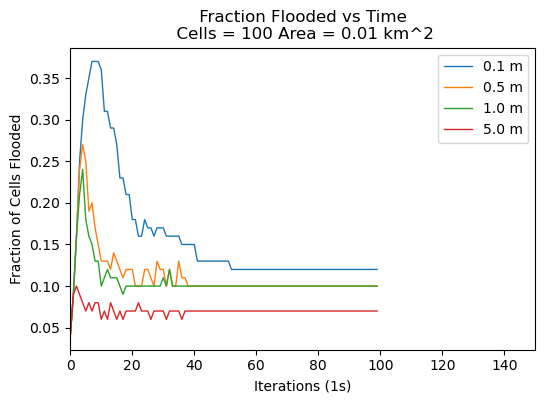

In [17]:
# plot each column in res['frac_flooded']
def flood_plot(results):
    # init figure
    fig, ax = plt.subplots(1,1, figsize = (6,4), dpi = 100)
    # for each column in frac flooded, plot
    for i in range(results['frac_flooded'].shape[1]):
        ax.plot(
            results['frac_flooded'][:,i], 
            '-',
            linewidth = 1,
            label = f'{results["thresholds"][i]} m')

    ax.legend()
    # add labels
    t = results['t']
    ax.set_xlabel(f'Iterations ({ t }s)')
    ax.set_ylabel('Fraction of Cells Flooded')
    
    cells = results["N"] * results["N"]
    area = results["area"] * cells / 1e6
    # add commas to area
    area = f'{area:,}'
    cells = f'{cells:,}'
    sim_params = f' Fraction Flooded vs Time \n  Cells = { cells  } Area = {area} km^2 '

    ax.set_title(f'{sim_params}')
    plt.close()
    return fig

flood = flood_plot(results)

# set xlim in flood
ax = flood.get_axes()[0]
ax.set_xlim(0, 150)

flood

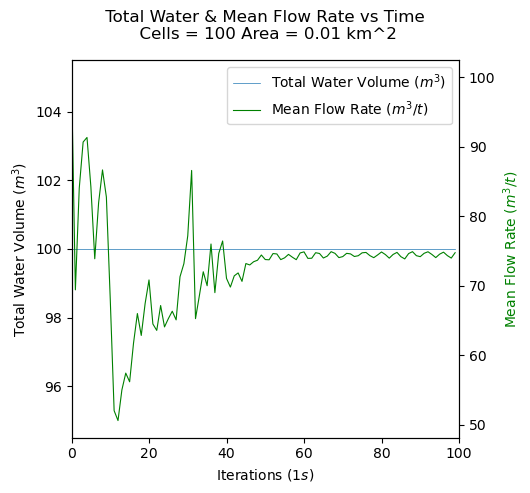

In [18]:
# plot with 2 y axis
def diagnostic_plot(results):
    # plot mean flow late and totmass (should be conserved)
    # results is dict of sim variables
    fig, ax = plt.subplots(1,1, figsize = (5,5), dpi = 100)
    p1 = ax.plot(
        results['tot_mass'],
        '-',
        linewidth = 0.5,
        label = 'Total Water Volume $(m^3)$')
    # on different y axis plot flow_rate
    twin = ax.twinx()

    p2 = twin.plot(
        results['flow_rate'], 
        '-g',
        linewidth = 0.8,
        label = 'Mean Flow Rate $(m^3/t)$',
    )
    # make left yaxis labels red
    ax.yaxis.label.set_color('red')
    ax.legend(handles = [p1[0], p2[0]])


    # set twin ylabel
    ax.set_ylabel('Total Water Volume $(m^3)$', color = 'black')
    twin.set_ylabel('Mean Flow Rate $(m^3/t)$', color = 'green')

    t = results['t']
    # set xlabel
    ax.set_xlabel(f'Iterations $({ t } s)$')

    cells = results["N"] * results["N"]
    area = results["area"] * cells / 1e6
    # add commas to area
    area = f'{area:,}'
    cells = f'{cells:,}'
    sim_params = f' Total Water & Mean Flow Rate vs Time \n  Cells = { cells  } Area = {area} km^2 '

    # pad title
    ax.set_title(f'{sim_params}', pad = 15)

    # do not show figure
    plt.close(fig)

    return fig

fig = diagnostic_plot(results)

# set xlim in flood
ax = fig.get_axes()[0]
ax.set_xlim(0, 100)

fig

# Minor Flood Stage 
# Moderate Flood Stage 
# Major Flood Stage

In [ ]:
# put batch results into dataframe
import pandas as pd
df = pd.DataFrame(batch_results)

# plot cell water 
fig, ax = plt.subplots(1,1, figsize = (5,5))

# group by tau on cell water
a = df.groupby('thresholds').aggregate({'frac_flooded': 'mean'})


for i,e in enumerate(a["fraction_flooded"]):
    plt.plot(e, label = f'{a.index[i]} m')
    
# label axes
plt.xlabel('Time (s)')
plt.ylabel('Fraction of Cells Flooded')
plt.legend()

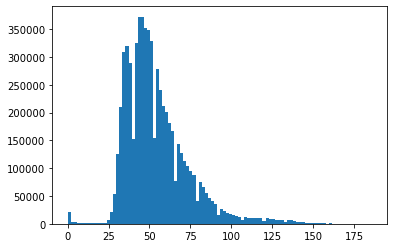

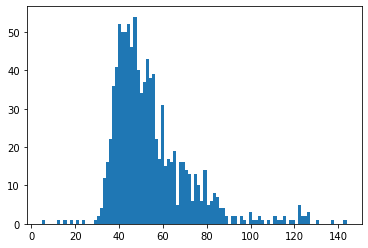

In [43]:
def resample_array(a, new_rows, new_cols): 
    '''
    This function takes an 2D numpy array a and produces a smaller array 
    of size new_rows, new_cols. new_rows and new_cols must be less than 
    or equal to the number of rows and columns in a.

    From https://stackoverflow.com/questions/8090229/resize-with-averaging-or-rebin-a-numpy-2d-array

    '''
    rows = len(a)
    cols = len(a[0])
    yscale = float(rows) / new_rows 
    xscale = float(cols) / new_cols

    # first average across the cols to shorten rows    
    new_a = np.zeros((rows, new_cols)) 
    for j in range(new_cols):
        # get the indices of the original array we are going to average across
        the_x_range = (j*xscale, (j+1)*xscale)
        firstx = int(the_x_range[0])
        lastx = int(the_x_range[1])
        # figure out the portion of the first and last index that overlap
        # with the new index, and thus the portion of those cells that 
        # we need to include in our average
        x0_scale = 1 - (the_x_range[0]-int(the_x_range[0]))
        xEnd_scale =  (the_x_range[1]-int(the_x_range[1]))
        # scale_line is a 1d array that corresponds to the portion of each old
        # index in the_x_range that should be included in the new average
        scale_line = np.ones((lastx-firstx+1))
        scale_line[0] = x0_scale
        scale_line[-1] = xEnd_scale
        # Make sure you don't screw up and include an index that is too large
        # for the array. This isn't great, as there could be some floating
        # point errors that mess up this comparison.
        if scale_line[-1] == 0:
            scale_line = scale_line[:-1]
            lastx = lastx - 1
        # Now it's linear algebra time. Take the dot product of a slice of
        # the original array and the scale_line
        new_a[:,j] = np.dot(a[:,firstx:lastx+1], scale_line)/scale_line.sum()

    # Then average across the rows to shorten the cols. Same method as above.
    # It is probably possible to simplify this code, as this is more or less
    # the same procedure as the block of code above, but transposed.
    # Here I'm reusing the variable a. Sorry if that's confusing.
    a = np.zeros((new_rows, new_cols))
    for i in range(new_rows):
        the_y_range = (i*yscale, (i+1)*yscale)
        firsty = int(the_y_range[0])
        lasty = int(the_y_range[1])
        y0_scale = 1 - (the_y_range[0]-int(the_y_range[0]))
        yEnd_scale =  (the_y_range[1]-int(the_y_range[1]))
        scale_line = np.ones((lasty-firsty+1))
        scale_line[0] = y0_scale
        scale_line[-1] = yEnd_scale
        if scale_line[-1] == 0:
            scale_line = scale_line[:-1]
            lasty = lasty - 1
        a[i:,] = np.dot(scale_line, new_a[firsty:lasty+1,])/scale_line.sum() 

    return a 


import geotiff

# Test: Decrease Resolution by resamp
kochi = geotiff.GeoTiff(r'./media/berlin.tif')

dem = np.array(kochi.read())
# if negative set to 0
dem[dem < 0] = 0

# hist of dem
plt.hist(dem.flatten(), bins = 100)
plt.show()

small_dem = resample_array(dem, 100, 10)
plt.hist(small_dem.flatten(), bins = 100)
plt.show()

689
24
4


Text(0.5, 0.98, 'Poisson-Cascade Model for Precipitation, 700mm/month average')

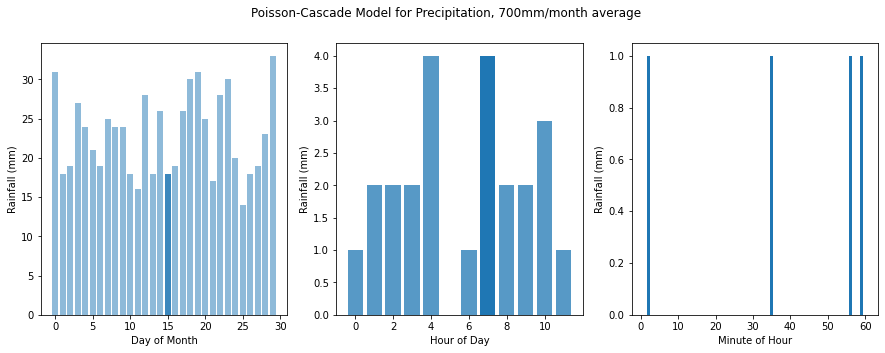

In [83]:
# input: curr_time(s) returns: rain (in m)
def s_to_h(s, step = 60):
    second_of_day = s*60 % (3600*24)
    
    return second_of_day/3600

# A Poisson-Cascade Model
# init 3 column subplots
fig, axs = plt.subplots(1,3, figsize = (15,5))

avg = 700

# poisson distribution for days in a month
monthly_rainfall = np.random.poisson(lam=avg/30, size=30)

# sample a day from monthly_rainfall
day = np.random.choice(range(len(monthly_rainfall)), size=1)

# poisson distribution for rainfall each hour
daily_rainfall = np.random.poisson(lam=monthly_rainfall[day]/12, size=12)

# sample an hour from daily_rainfall
hour = np.random.choice(range(len(daily_rainfall)), size=1)
# poisson distribution for rainfall each minute
hourly_rainfall = np.random.poisson(lam=daily_rainfall[hour]/60, size=60)

# bar plot of monthly rainfall
axs[0].bar(np.arange(30), monthly_rainfall, alpha = 0.5)
# get color of bar
bar_color = axs[0].patches[3].get_facecolor()
axs[0].bar(day, monthly_rainfall[day], color = bar_color, alpha = 0.75)
axs[0].set_xlabel('Day of Month')

print(np.sum(monthly_rainfall))

# clear plot
axs[1].bar(np.arange(12), daily_rainfall, alpha = 0.75)
bar_color = axs[1].patches[0].get_facecolor()
axs[1].bar(hour, daily_rainfall[hour], color = bar_color, alpha = 1)
# add x label
axs[1].set_xlabel('Hour of Day')
print(np.sum(daily_rainfall))

axs[2].bar(np.arange(1,61), hourly_rainfall)
axs[2].set_xlabel('Minute of Hour')
print(np.sum(hourly_rainfall))

# set y label for all
for ax in axs:
    ax.set_ylabel('Rainfall (mm)')

# Set overall tite
fig.suptitle(f'Poisson-Cascade Model for Precipitation, {avg}mm/month average')

In [117]:
hourly_rainfall

def get_rain(iter, avg = 700):
    # poisson distribution for days in a month
    monthly_rainfall = np.random.poisson(lam=avg/30, size=30)

    # sample a day from monthly_rainfall
    day = np.random.choice(range(len(monthly_rainfall)), size=1)

    # poisson distribution for rainfall each hour
    daily_rainfall = np.random.poisson(lam=monthly_rainfall[day]/12, size=12)

    # sample an hour from daily_rainfall
    hour = np.random.choice(range(len(daily_rainfall)), size=1)
    # poisson distribution for rainfall each minute
    hourly_rainfall = np.random.poisson(lam=daily_rainfall[hour]/60, size=60)

    rain_m = hourly_rainfall[iter]
    
    return  rain_m / 1000


tot = 0

for i in range(30):

    

    iters = np.arange(0, 60*12)
    rain = np.zeros(len(iters))

    for i in iters:

        s = int(i%60)

        rain[i] = get_rain(s)

    tot+=np.sum(rain)

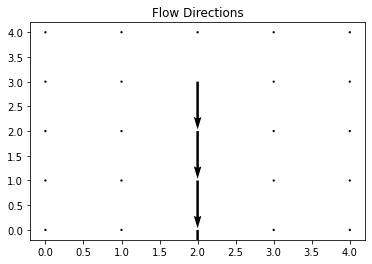

In [ ]:
# TODO: cast direction to arrows

# transform ij indexing to cartesian xy
def ij_to_xy(ij):
    # Take an i,j tuple and return x,y tuple
    i,j = ij[0], ij[1]

    return (j, -i)

ij_dict = make_direction_dict()
ij_to_xy(get_direction_idxs(7))

def quiver_directions(dir_grid):
    # iterate through dir_grid
    scale = dir_grid.shape[0]*1.4
    length = dir_grid.shape[0]
    N = dir_grid.size

    X, Y = np.meshgrid(np.arange(length), np.arange(length))
    U = np.zeros(N)
    V = np.zeros(N)

    for i in range(length):
        for j in range(length):
            cell = int(dir_grid[i,j])


            # get first key
            keys = get_direction_keys(cell)
            if not keys:
                continue

            # get i,j of key
            ii = 0
            jj = 0
            for key in keys:
                t_ii, t_jj = get_direction_idxs(key)
                ii += t_ii
                jj += t_jj

            # normalize ii,jj 
            tot = ii + jj
            ii /= tot
            jj /= tot


            # get arrow direction
            u, v = ij_to_xy((ii,jj))

            idx = np.ravel_multi_index((i,j), dir_grid.shape)

            U[idx] = u 
            V[idx] = v 

    # quiver plot small arrows
    plt.quiver(X, Y, U, V, scale = scale)
    # set title
    plt.title('Flow Directions')

    return u,v


down_stream = np.zeros((5,5))
down_stream[0:4,2] = 128
u,v = quiver_directions(down_stream)

#u,v = quiver_directions(beauford[...,3])